<a href="https://colab.research.google.com/github/Aditya-Ramachandran/Sketch-To-Image-Conversion/blob/master/Sketch_To_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading the libraries 

In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import time

In [2]:
# sometimes cell results a long line text which is bigger than the screen resolution, so it is shown a scrollbar with no wrapping. This code
# is used to activate the font wrapping in the output scroll bar so that the whole output can be displayed with font wrap activated 

# from IPython.display import HTML, display

# def my_css():
#    display(HTML("""<style>table.dataframe td{white-space: nowrap;}</style>"""))

# get_ipython().events.register('pre_run_cell', my_css)

# Loading the dataset

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
input_path = '/content/gdrive/My Drive/pokemon_pix2pix_dataset'

In [5]:
def image_loader(image_file):
  image_read = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image_read)
  dim = tf.shape(image)[1]
# print(dim)
  dim = dim // 2
# print(dim)
  input = image[:, :dim, :]
  original = image[:, dim:, :]
  input = tf.cast(input, tf.float32)
  original = tf.cast(original, tf.float32)
  return input, original

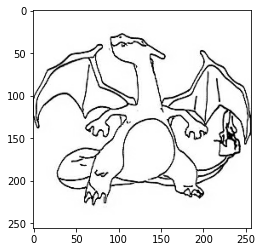

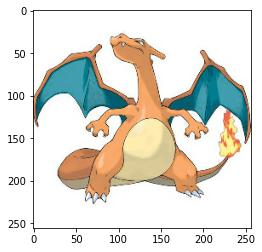

In [6]:
inp_img, orig_img = image_loader(input_path+'/train/5.jpg')
plt.figure()
plt.imshow(inp_img/255.0)
plt.figure()
plt.imshow(orig_img/255.0)

# Data Augentation



* Data augmentation in data analysis are techniques used to increase the 
amount of data by adding slightly modified copies of already 
existing data or newly created synthetic data from existing data. 

* It acts as a regularizer and helps reduce overfitting when training 
a machine learning model





In [7]:
#For better accuracy and faster convergence, I am planning on resizing the image and normalizing the pixel values in the image and then 
# flipping the images on both left and right because the user can provide images which can be mirrored along the X-axis and hence the model
# should be able to work for those images and not discard them 
# planning also to add vertical flipping cause some images maybe mirrored along the Y-axis 


def resize_image(input,original, height, width):
  input = tf.image.resize(input[height,width],method= tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return input, original


def cutout(input, original):
  stacked = tf.stack([input, original], axis=0)
  cut_image = tf.image.random_crop(stacked, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
  return cut_image[0], cut_image[1]


# Normalizing the images to [-1, 1]
def normalize(input, original):
  input = (input / 127.5) - 1
  original = (original / 127.5) - 1
  return input, original


def add_noise(input, original):
  input,original = resize_image(input,original, 256, 256)
  input,original = cutout(input,original)
  if tf.random.uniform(()) > 0.5:
    input = tf.image.flip_left_right(input)
    original = tf.image.flip_left_right(original)
  return input,original

# Building the Generator 

The generator of your pix2pix cGAN is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler). 

* Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU

* Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU

* There are skip connections between the encoder and decoder (as in the U-Net).


## Downsampler 

In [8]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [9]:
# down_model = downsample(3, 4)
# down_result = down_model(tf.expand_dims(inp, 0))
# print (down_result.shape)

## Upsampler 

In [10]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [11]:
# up_model = upsample(3, 4)
# up_result = up_model(down_result)
# print (up_result.shape)

## Generator Function 


In [20]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)




# Building the Discriminator 

The discriminator in the pix2pix cGAN is a convolutional PatchGAN classifier—it tries to classify if each image patch is real or not rea

* Each block in the discriminator is: Convolution -> Batch normalization -> Leaky ReLU.

* The shape of the output after the last layer is `(batch_size, 30, 30, 1).`

* Each `30 x 30` image patch of the output classifies a `70 x 70` portion of the input image.

* The discriminator receives 2 inputs

  * The input image and the target image, which it should classify as real.
  * The input image and the generated image (the output of the generator), which it should classify as fake.
  * Use `tf.concat([inp, tar], axis=-1)` to concatenate these 2 inputs together.

## Discriminator function 

In [22]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  input = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  target = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')

  concat = tf.keras.layers.concatenate([input, target])  

  layer1 = downsample(64, 4, False)(concat)  
  layer2 = downsample(128, 4)(layer1)  
  layer3 = downsample(256, 4)(layer2)  

  pad1 = tf.keras.layers.ZeroPadding2D()(layer3)  
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(pad1)  

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(pad2)  

  return tf.keras.Model(inputs=[input, target], outputs=last)